In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from imutils import paths
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from skimage import filters
from skimage.transform import resize
from skimage.feature import hog
import os
import pandas as pd


In [5]:
path = "C:/Users/ligra/Desktop/диплом/fashion-dataset/images/"
weights = [1, 0.2, 0.2, 0.4]

In [6]:
#prerparing dataset
def preparing_dataset():
    df = pd.read_csv('C:/Users/ligra/Desktop/диплом/fashion-dataset/styles.csv', error_bad_lines=False)
    #looking for classes where the number of images is < 8, so that each class falls into each of the samples
    del_index = df.articleType.value_counts().reset_index().rename(columns={'index':'articleType', 'articleType':'count'})
    del_index =del_index[del_index['count'] < 9]

    flags_buf  = df.articleType.reset_index()
    del_indexes = []

    for i in del_index.articleType:
        array_buf = flags_buf[flags_buf['articleType'] == i]
        del_indexes = array_buf['index']
        df = df.drop(del_indexes)
    
    #removing missing images from dataset
    missing_img = []
    for idx, line in df.iterrows():
        if not os.path.exists(os.path.join('C:/Users/ligra/Desktop/диплом/fashion-dataset/', 'images', str(line.id)+'.jpg')):
            missing_img.append(idx)
        
    df.drop(df.index[missing_img], inplace=True)
    return df

def split_clasters(df):
    claster_names = {}
    for claster_name in df.articleType:
        df_id = df[df['articleType'] == claster_name]
        list_id = list(df_id.reset_index().id)
        if len(list_id) > 5:
            claster_names[claster_name] = list_id[0:5]
        else:
            claster_names[claster_name] = list_id
    return claster_names  

In [7]:
#image processing functions
def hsv(path):
    img = plt.imread(path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    return hist

def hog_f(path):
    img = plt.imread(path)
    img = resize(img, (128,64))
    hog_img, fd = hog(img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    return hog_img.reshape(hog_img.shape[0],1)

def sobel(path):
    img = plt.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel_img = filters.sobel(img)
    sobel_img  = filters.gaussian(sobel_img, sigma=2.0)
    return sobel_img.flatten()

def texture(path):
    img = plt.imread(path)
    g_kernel = cv2.getGaborKernel((21, 21), 8.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    texture_img = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)
    return texture_img.flatten()



In [8]:
#getting features
def get_features(img_num):
    img_path = path + img_num + ".jpg"
    hsv_vector = hsv(img_path)
    sobel_vector = sobel(img_path)
    texture_vector = texture(img_path)
    hog_vector = hog_f(img_path)  
    return [hsv_vector, sobel_vector, texture_vector, hog_vector]


def features_dataset(df):
    features = {}
    for claster_name in df:
        if claster_name not in features:
            features[claster_name] = {}
        for img_num in df[claster_name]:
            features[claster_name][img_num] = get_features(img_num)
    return features

In [9]:
#functions for saving and loading features datasets
def save_in_pickle(data, pickle_file):
    file = open(pickle_file,"wb")
    pickle.dump(data,file)
    file.close()
    
def load_from_pickle(pickle_file):
    file = open(pickle_file,'rb')
    pickle_data = pickle.load(file)
    file.close()
    return pickle_data

In [53]:
#image similarity assessment
def cosine(a,b):
    dot = np.dot(a.T, b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = (dot / norma) / normb
    return cos

def cosine_score(test_features, train_features):
    score = 0
    for num_feature in range(len(test_features)):
        if len(test_features[num_feature]) != len(train_features[num_feature]):
            min_size = min(len(test_features[num_feature]), len(train_features[num_feature]))
            test_features[num_feature] = test_features[num_feature][0:min_size]
            train_features[num_feature] = train_features[num_feature][0:min_size]
        score += cosine(train_features[num_feature],test_features[num_feature])  
    return score/4
   

In [47]:
#main function
def recommend_images(img_test):
    lead_similarity = {}
    test_features = get_features(img_test)
    train_classes = list(train_features.keys())
    for key in train_classes:
        id_img = list(train_features[key].keys())
        if id_img != []:
            buf_features = train_features[key][id_img[0]]
            buf_score = cosine_score(test_features, buf_features)
            lead_similarity[key] = buf_score
    
    #selection of top 3 similar images among class leaders
    lead_score = []
    for key in lead_similarity:
        lead_score.append(lead_similarity[key])
    
    lead_score.sort(reverse=True)
    top_lead = []
    for key in lead_similarity:
        if lead_similarity[key] == lead_score[0] or lead_similarity[key] == lead_score[1] or lead_similarity[key] == lead_score[2]:
            top_lead.append(key)
    
   #selection top 3 images among all 
    top3_score = {}
    
    for type_name in top_lead:
        id_img = list(train_features[type_name].keys())
        buf_score_array = []
        if id_img != []:
            for i in  range(len(id_img)):
                buf_features = train_features[type_name][id_img[i]]
                buf_score = cosine_score(test_features, buf_features)
                buf_score_array.append(buf_score)
        
        avg_score = sum(buf_score_array) / len(buf_score_array)
        top3_score[type_name] = avg_score
    
    max_score = 0
    result = ''
    
    for key in top3_score:
        if top3_score[key] > max_score:
            max_score = top3_score[key]
            result = key
    
    return result

In [12]:
def scatter_plot(accuracy_processed_img, accuracy_all_img):
    x = [i for i in range(len(accuracy_processed_img))]
    plt.plot(x, accuracy_processed_img, label='precision', color = 'red')
    plt.plot(x, accuracy_all_img, label='recall', color = "green")
    plt.xlabel('X input')
    plt.ylabel("Y output")
    plt.legend()
    plt.show()

In [10]:
def recommendImages2(testImage):
    lead_similarity = {}
    test_features = get_features(testImage)
    train_classes = list(train_features.keys())
    for key in train_classes:
        id_img = list(train_features[key].keys())
        buf_array = []
        if id_img != []:
            for i in  range(len(id_img)):
                buf_features = train_features[key][id_img[i]]
                buf_score = cosine_score(test_features, buf_features)
                buf_array.append(buf_score[0][0])
        
            lead_similarity[key] = sum(buf_array)/len(buf_array)
             
    
    lead_score = []
    result = []
    for key in lead_similarity:
        lead_score.append(lead_similarity[key])
    lead_score.sort(reverse=True)
    for key in lead_similarity:
        if lead_similarity[key] == lead_score[0] or lead_similarity[key] == lead_score[1] or lead_similarity[key] == lead_score[2] or lead_similarity[key] == lead_score[3]:
            result.append(key)
    
    return result
    
    




In [13]:
df = preparing_dataset()


C:\Users\ligra\AppData\Local\Temp/ipykernel_113584/3924117327.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  df = preparing_dataset()
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 357

In [15]:
tags_train, tags_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df['articleType'])

In [25]:
tags_train = split_clasters(tags_train)
tags_test = split_clasters(tags_test)

In [55]:
#recommend_images('57771')

In [12]:
#train_features = features_dataset(tags_train)
#save_in_pickle(train_features, "train_features")

In [16]:
#loading file with features
train_features = load_from_pickle("train_features")

In [ ]:
k = 4
accuracy_processed_img = []
accuracy_all_img = []
proccesed_imgs = 0
correct_answer = 0
all_score = 0


for claster_name in tags_test:
    for img_test in tags_test[claster_name]:
        try:
            #print("img: ", img_test)
            result = recommend_images(str(img_test))
            #print("correct answer: ", claster_name)
            #print("predicted result: ", result)

            if claster_name == result :
                correct_answer += 1
            proccesed_imgs += 1
            #the number of correct definitions in relation to the number of processed images
            accuracy_processed_img.append(correct_answer/proccesed_imgs)
            #the number of correct definitions in relation to the number of all images
            accuracy_all_img.append(correct_answer/499)
            #print("\n")
        
        except:
            pass
            #print('ERROR')


In [32]:
#accuracy output
print(correct_answer/proccesed_imgs)

0.2623456790123457


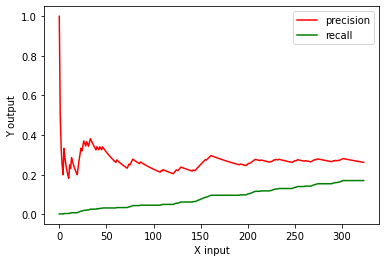

In [28]:
scatter_plot(accuracy_processed_img, accuracy_all_img)